<a href="https://colab.research.google.com/github/darkginka/Diet-Recommanded-System/blob/main/DRS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project Start**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

In [ ]:
####### dataset #######
food_nutrition = pd.read_csv("/content/drive/MyDrive/dataset/food_nutrition.csv")
disease_nutrition = pd.read_csv("/content/drive/MyDrive/dataset/disease_nutrition.csv",encoding='unicode_escape')

In [ ]:
#food_nutrition.info()
for col in food_nutrition.columns:
    print(col)
# food_nutrition.head()

In [ ]:
# disease_nutrition.info()
disease_nutrition.head()

**Part-1**

In [ ]:
####### Methods #######
def get_disease(disease_name):
	if(disease_name not in list(disease_nutrition["disease"])):
		return False
	else:
		return disease_nutrition[disease_nutrition.disease==disease_name]["disease"].values[0]

def get_disease_name(disease_id):
	return disease_nutrition[disease_nutrition.disease_id == disease_id]["disease"].values[0]

def get_disease_id(disease):
	return disease_nutrition[disease_nutrition.disease == disease]["disease_id"].values[0]

def get_disease_ie(disease):
	return disease_nutrition[disease_nutrition.disease == disease]["ineficient_nutritions"].values[0]

In [ ]:
####### get-set Data #######
users_disease = input("Enter Disease Name: ")
disease_name = get_disease(users_disease)
if(disease_name==False):
  print("Disease Not Found")
else:
  disease_id = get_disease_id(disease_name)
  i= disease_id-101
  print(disease_nutrition.iloc[i])         
  disease_ie = get_disease_ie(disease_name)
  # print(disease_ie)
#Convert disease-nutritions column value into list
  dis_list = list(disease_ie.split(" "))
#Convert food column into list
  col_list = food_nutrition.columns.values.tolist()
 # print(dis_list)
  for ele in dis_list:
    if(ele==""):
      dis_list.remove(ele)
  print(dis_list)

**Part-2**

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
ax = sns.heatmap(food_nutrition.corr(),annot=True)
plt.show()

In [ ]:
food_nutrition[dis_list].hist(bins=50, figsize=(10,10))
plt.show()

**Preprocessing data**

In [85]:
from sklearn.preprocessing import MinMaxScaler

In [86]:
columns_to_cluster = dis_list

In [88]:
#MinMaxScaler
#Transform features by scaling each feature to a given range.Here is an example to scale a data matrix to the [0, 1] range:
mms = MinMaxScaler()
food_scaled = mms.fit_transform(food_nutrition[columns_to_cluster])
print("Scaled Food Value: ", food_scaled[0,:])

Scaled Food Value:  [0.02435152 0.         0.00205714 0.0097522  0.0017196  0.00059893
 0.00053548]


In [ ]:
columns_to_cluster_scaled = dis_list

In [ ]:
df_food_scaled = pd.DataFrame(food_scaled, columns=columns_to_cluster_scaled)

In [ ]:
ax = sns.heatmap(df_food_scaled.corr(), annot=True)
plt.show()

**Training the model**

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
n_clusters = range(2,21)
ssd = []
sc = []
for n in n_clusters:
    km = KMeans(n_clusters=n, max_iter=300, n_init=10, init='k-means++', random_state=42)
    km.fit(food_scaled)
    preds = km.predict(food_scaled) 
    centers = km.cluster_centers_ 
    ssd.append(km.inertia_) 
    score = silhouette_score(food_scaled, preds, metric='euclidean')
    sc.append(score)
    print("Number of Clusters = {}, Silhouette Score = {}".format(n, score))

Number of Clusters = 2, Silhouette Score = 0.6377703197801713
Number of Clusters = 3, Silhouette Score = 0.5871792456100594
Number of Clusters = 4, Silhouette Score = 0.5929653272709893
Number of Clusters = 5, Silhouette Score = 0.3851938731556179
Number of Clusters = 6, Silhouette Score = 0.39432539885734386
Number of Clusters = 7, Silhouette Score = 0.40702476568428386
Number of Clusters = 8, Silhouette Score = 0.36417582666139425
Number of Clusters = 9, Silhouette Score = 0.3723514878174952
Number of Clusters = 10, Silhouette Score = 0.3747458853948939
Number of Clusters = 11, Silhouette Score = 0.37697321858484817
Number of Clusters = 12, Silhouette Score = 0.3896183931290962
Number of Clusters = 13, Silhouette Score = 0.38698192158325445
Number of Clusters = 14, Silhouette Score = 0.34240756750688967
Number of Clusters = 15, Silhouette Score = 0.2939658435603981
Number of Clusters = 16, Silhouette Score = 0.2930703692588652


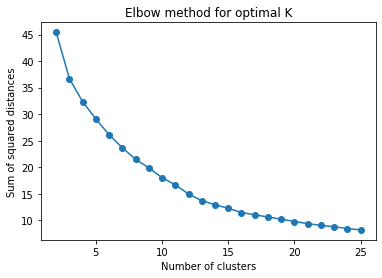

In [92]:
plt.plot(n_clusters, ssd, marker='.', markersize=12)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow method for optimal K')
plt.show()

In [138]:
k=6
model = KMeans(n_clusters=k, random_state=42).fit(food_scaled)
pred = model.predict(food_scaled)
print('10 first clusters: ', model.labels_[:10])

10 first clusters:  [1 1 1 1 1 1 1 1 1 1]


**Visualizing the clusters**

In [ ]:
df_food_scaled['cluster'] = model.labels_
df_food_scaled['cluster'].value_counts().plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Amount of food')
plt.title('Amount of foods per cluster')
plt.show()

In [ ]:
display(df_food_scaled['cluster'].value_counts())
minor_cluster = df_food_scaled['cluster'].value_counts().tail(1)
print("Amount of food in the smallest cluster: ", int(minor_cluster.values))

In [ ]:
df_food_joined = pd.concat([food_nutrition,df_food_scaled], axis=1).set_index('cluster')

for cluster in range(k):
    display(df_food_joined.loc[cluster, ['Description']].sample(frac=1).head(10))

**Applying PCA to visualize the clusters**

In [142]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=3, random_state=42)
food_pca = pca.fit_transform(food_scaled)
pca.explained_variance_ratio_.sum()

In [144]:
df_pca = pd.DataFrame(food_pca, columns=['C1', 'C2', 'C3'])
df_pca['cluster'] = model.labels_
df_pca.head()

,C1,C2,C3,cluster
0,-0.042362,-0.005529,-0.002430,1
1,-0.042035,-0.015486,0.002056,1
2,-0.041687,-0.007586,-0.002269,1
3,-0.041843,-0.004141,-0.004138,1
4,-0.041687,-0.007586,-0.002269,1


In [145]:
sampled_clusters_pca = pd.DataFrame()

for c in df_pca.cluster.unique():
    df_cluster_sampled_pca = df_pca[df_pca.cluster == c].sample(n=int(minor_cluster), random_state=42)
    sampled_clusters_pca = pd.concat([sampled_clusters_pca,df_cluster_sampled_pca], axis=0)
sampled_clusters_pca.cluster.value_counts()

1    111
0    111
2    111
3    111
4    111
Name: cluster, dtype: int64

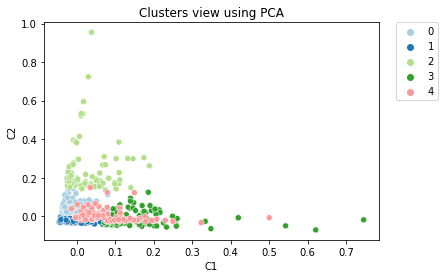

In [146]:
sns.scatterplot(x='C1', y='C2', hue='cluster', data=sampled_clusters_pca, legend="full", palette='Paired')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Clusters view using PCA')
plt.show()

**Predicting users clusters**

In [158]:
user_pred = model.predict(food_scaled)
print('10 first users clusters: ', user_pred[:10])

15 first users clusters:  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [ ]:
user_cluster = pd.DataFrame(food_scaled, columns=columns_to_cluster_scaled)
user_cluster['cluster'] = user_pred

user_cluster['cluster'].value_counts().plot(kind='bar', color='green')
plt.xlabel('Cluster')
plt.ylabel('Amount of food')
plt.title('Amount of food in the users clusters')
plt.show()

In [ ]:
df_user_food_joined = pd.concat([food_nutrition,user_cluster], axis=1).set_index('cluster')
for cluster in user_cluster['cluster'].unique():
    display(df_user_food_joined.loc[cluster, ['Description']].sample(frac=1).head(10))

**Recommending Food**

In [ ]:
df_user_food_joined.reset_index(inplace=True)
cluster_pct = df_user_food_joined.cluster.value_counts(normalize=True)*20

if int(cluster_pct.round(0).sum()) < 20:
    cluster_pct[cluster_pct < 0.5] = cluster_pct[cluster_pct < 0.5] + 1.0
    
display(cluster_pct)
print('Total food: ', int(cluster_pct.round(0).sum()))

In [ ]:
df_food_joined.reset_index(inplace=True)
df_food_joined.head(3)

In [ ]:
df_user_food_joined['cluster_pct'] = df_user_food_joined['cluster'].apply(lambda c: cluster_pct[c])
df_user_food_joined.drop(columns=columns_to_cluster_scaled, inplace=True)
df_user_food_joined.head(3)

In [172]:
final_Food = pd.DataFrame()

for ncluster, pct in cluster_pct.items():
    songs = df_food_joined[df_food_joined['cluster'] == ncluster].sample(n=int(round(pct, 0)))
    final_Food = pd.concat([final_Food,songs], ignore_index=True)
    if len(final_Food) > 20 :
        flag = 20 - len(final_Food)
        final_Food = final_Food[:flag]
final_Food.head(3)

,index,cluster,Category,Description,NutrientDataBankNumber,Carotene,Cryptoxanthin,Carbohydrate,Cholesterol,Choline,...,Vitamin_C,Vitamin_E,Vitamin_K,SaturatedFat,Fiber,Riboflavin,Vitamin_A,Zinc,Vitamin_D,Vitamin_E
0,1665,1,Venison or deer,"Venison or deer, noodles, and vegetables inclu...",27336300,844,1,13.64,28,33.8,...,5.6,1.17,14.0,0.011939,0.032468,0.009943,0.013909,0.015578,0.006888,0.007831
1,2781,1,Bread,"Bread, native, water, toasted, Puerto Rican style",51106020,1,0,57.11,0,9.5,...,0.0,0.44,1.2,0.009430,0.043290,0.022114,0.000000,0.008699,0.018096,0.002945
2,4836,1,Pear,"Pear, canned, in syrup",63137140,0,0,15.15,0,3.1,...,0.9,0.07,0.3,0.000024,0.032468,0.000629,0.000000,0.000809,0.000299,0.000469


In [173]:
final_Food[['Description']]

,Description
0,"Venison or deer, noodles, and vegetables inclu..."
1,"Bread, native, water, toasted, Puerto Rican style"
2,"Pear, canned, in syrup"
3,"Quinoa, no added fat"
4,"Chocolate milk, made from dry mix, NS as to ty..."
5,"Bulgur, NS as to fat"
6,"Greens, frozen, cooked, no added fat"
7,Banana nectar
8,"Chicken, prepackaged or deli, luncheon meat"
9,"Iced Coffee, pre-lightened and pre-sweetened"
